# Bone Fracture Detection 

Trained on upper limb x-ray images.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/umedmi-kaggle/

/content/drive/MyDrive/umedmi-kaggle


## Loading Dataset

In [ ]:
def load_data():
  images = []
  labels = []
  for dirName, _, fileList in os.walk('.'):
      category = dirName.split('/')[-1]
      for file in fileList:
        if category == '.':
          continue
        labels.append(dirName.split('/')[-1])
        print(file)
        image = cv2.imread(os.path.join(dirName, file), 0)
        images.append(image)
  return np.array(images, dtype=object), np.array(labels, dtype=object)

In [ ]:
x_raw, y_raw = load_data()

Streaming output truncated to the last 5000 lines.
positive (4342).png
positive (4501).png
positive (4419).png
positive (4338).png
positive (4530).png
positive (4669).png
positive (4527).png
positive (4363).png
positive (4461).png
positive (4333).png
positive (4341).png
positive (4366).png
positive (4562).png
positive (4309).png
positive (4556).png
positive (4416).png
positive (4590).png
positive (4343).png
positive (4386).png
positive (4450).png
positive (4538).png
positive (4554).png
positive (4659).png
positive (4509).png
positive (4665).png
positive (4370).png
positive (4587).png
positive (4641).png
positive (4492).png
positive (4350).png
positive (4574).png
positive (4469).png
positive (4475).png
positive (4551).png
positive (4654).png
positive (4418).png
positive (4537).png
positive (4592).png
positive (4545).png
positive (4398).png
positive (4534).png
positive (4673).png
positive (4313).png
positive (4553).png
positive (4611).png
positive (4522).png
positive (4454).png
positive 

In [ ]:
df_labels = pd.DataFrame(y_raw)
df_labels.value_counts(normalize = True)*100

negative    57.771494
positive    42.228506
dtype: float64

## Data Preprocessing

### Cleaning Missing Data

In [ ]:
dropX = np.where(pd.Series(x_raw).isnull())

In [ ]:
x_clean = np.delete(x_raw, dropX)
y_clean = np.delete(y_raw, dropX)

In [ ]:
del x_raw
del y_raw

### Resizing

In [ ]:
Width = []
Height = []
for img in x_clean:
  Width.append(img.shape[0])
  Height.append(img.shape[1])

In [ ]:
df_labels = pd.DataFrame({'Width':Width, 'Height':Height})
df_labels.value_counts(normalize = True)*100

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(Width, Height, color='blue', alpha=0.5, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [ ]:
# Resizing images 
def images_prep(image_dataset):
    resized = [cv2.resize(img, (250, 250)) for img in image_dataset]
    normalized = [cv2.normalize(img, None, norm_type=cv2.NORM_MINMAX) for img in resized]
    return np.array(normalized) 

x_resized = images_prep(x_clean)   
del x_clean


In [ ]:
#for VGG
# Resizing images 
def images_prep(image_dataset):
    resized = [cv2.resize(img, (250, 250)) for img in image_dataset]
    normalized = [cv2.normalize(img, None, norm_type=cv2.NORM_MINMAX) for img in resized]
    reshaped = [np.dstack((img, img, img)) for img in normalized]
    return np.array(reshaped) 

x_resized = images_prep(x_clean)   
del x_clean

### Data Splitting

In [ ]:
# One Hot Encoding 
ohe = OneHotEncoder(sparse=False)

labels_encoded = ohe.fit(y_clean.reshape(-1,1))
labels_encoded = ohe.transform(y_clean.reshape(-1,1))
del y_clean

In [ ]:
ohe.categories_

[array(['negative', 'positive'], dtype=object)]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_resized, labels_encoded, test_size=0.2, random_state=42,shuffle=True,stratify=labels_encoded)

In [ ]:
# Reshaping 
(a,b,c)=x_train.shape 
x_train = np.reshape(x_train, (a, b, c, 1))


(a,b,c)=x_test.shape 
x_test = np.reshape(x_test, (a, b, c, 1))

## Model architecture

In [ ]:
rows, cols,color = (250,250,1)
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', strides=(1, 1),input_shape=(rows,cols,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Conv2D(128, (1, 1), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Dropout(0.25))


model.add(Conv2D(32, (1, 1), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(16, (1, 1), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Dropout(0.1))
model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))


model.add(Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 250, 250, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 128)       4224      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 128)     

In [ ]:
def Loss_Acc_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
    fig.suptitle("Model Performance", fontsize = 25, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')

    ax1.plot(range(1, len(acc) + 1), acc,  color='#185fad')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, color='orange')
    ax1.set_title('History of Accuracy by Epoch', fontsize=20)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=18)
    ax1.legend(['training', 'validation'], fontsize=18)


    ax2.plot(range(1, len(loss) + 1), loss, color='#185fad')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, color='orange')
    ax2.set_title('History of Loss by Epoch', fontsize=20)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Binary Crossentropy (Loss)', fontsize=18)
    ax2.legend(['training', 'validation'], fontsize=18)
    
    plt.tight_layout()
    plt.show()
    


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), shuffle=True, epochs=40, batch_size=64,callbacks=[es])


Epoch 1/40
394/394 [==============================] - 102s 228ms/step - loss: 0.7940 - accuracy: 0.5730 - val_loss: 0.6730 - val_accuracy: 0.5777
Epoch 2/40
394/394 [==============================] - 88s 223ms/step - loss: 0.6697 - accuracy: 0.5822 - val_loss: 0.6666 - val_accuracy: 0.5812
Epoch 3/40
394/394 [==============================] - 88s 223ms/step - loss: 0.6592 - accuracy: 0.6007 - val_loss: 0.6477 - val_accuracy: 0.6250
Epoch 4/40
394/394 [==============================] - 88s 222ms/step - loss: 0.6457 - accuracy: 0.6229 - val_loss: 0.6484 - val_accuracy: 0.6190
Epoch 5/40
394/394 [==============================] - 88s 222ms/step - loss: 0.6355 - accuracy: 0.6398 - val_loss: 0.6241 - val_accuracy: 0.6595
Epoch 6/40
394/394 [==============================] - 87s 222ms/step - loss: 0.6228 - accuracy: 0.6536 - val_loss: 0.6273 - val_accuracy: 0.6471
Epoch 7/40
394/394 [==============================] - 90s 229ms/step - loss: 0.6104 - accuracy: 0.6634 - val_loss: 0.6157 - val_a

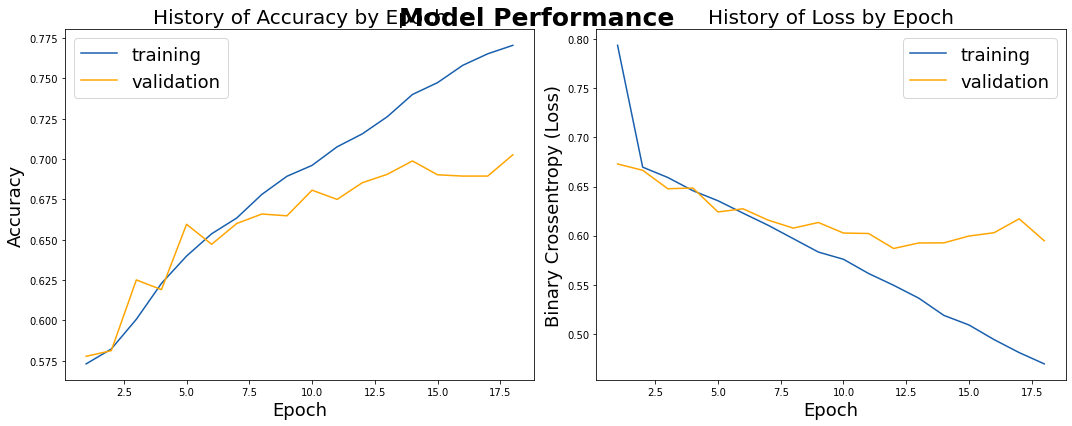

In [ ]:
Loss_Acc_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)

filepath = 'bone_fracture_baseline_model_modified.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1, save_best_only=True,mode='min')

callbacks = [checkpoint, es, reduce_lr]

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), shuffle=True, epochs=40, batch_size=64,callbacks=[callbacks])

Epoch 1/40
394/394 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.5948
Epoch 1: val_loss improved from inf to 0.64451, saving model to bone_fracture_baseline_model_modified.h5
394/394 [==============================] - 32s 79ms/step - loss: 0.6680 - accuracy: 0.5948 - val_loss: 0.6445 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 2/40
393/394 [============================>.] - ETA: 0s - loss: 0.6370 - accuracy: 0.6370
Epoch 2: val_loss improved from 0.64451 to 0.62447, saving model to bone_fracture_baseline_model_modified.h5
394/394 [==============================] - 30s 77ms/step - loss: 0.6370 - accuracy: 0.6369 - val_loss: 0.6245 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 3/40
393/394 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.6470
Epoch 3: val_loss improved from 0.62447 to 0.61435, saving model to bone_fracture_baseline_model_modified.h5
394/394 [==============================] - 30s 77ms/step - loss: 0.6238 - accuracy: 0.6470 - val_

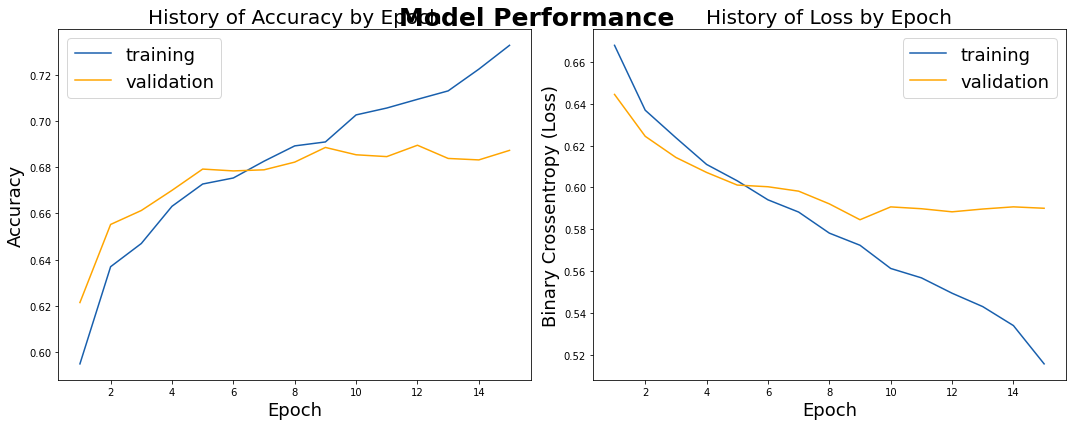

In [ ]:
Loss_Acc_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
# Predict classes 
predict_x=model.predict(x_test) 
#y_pred=np.argmax(predict_x,axis=1)
y_pred=np.round(predict_x).astype(int)

In [ ]:
target=['negative', 'positive']

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),2))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, predict_x,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=target))

Accuracy: 0.69
Precision: 0.6879
Recall: 0.6886
F1 Score: 0.6772
ROC AUC Score: 0.7395
		Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.84      0.76      3636
    positive       0.68      0.49      0.57      2658

    accuracy                           0.69      6294
   macro avg       0.69      0.66      0.66      6294
weighted avg       0.69      0.69      0.68      6294



In [ ]:
target=['negative', 'positive']

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),2))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, predict_x,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=target))

Accuracy: 0.7
Precision: 0.703
Recall: 0.7081
F1 Score: 0.7009
ROC AUC Score: 0.7653
		Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.82      0.76      3636
    positive       0.69      0.55      0.61      2658

    accuracy                           0.71      6294
   macro avg       0.70      0.68      0.69      6294
weighted avg       0.70      0.71      0.70      6294



#### After Normalization


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)

filepath = 'bone_fracture_baseline_model.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1, save_best_only=True,mode='min')

callbacks = [checkpoint, es, reduce_lr]

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), shuffle=True, epochs=40, batch_size=64,callbacks=[es])

Epoch 1/40
394/394 [==============================] - 105s 232ms/step - loss: 0.6582 - accuracy: 0.6003 - val_loss: 0.6338 - val_accuracy: 0.6382
Epoch 2/40
394/394 [==============================] - 91s 231ms/step - loss: 0.6249 - accuracy: 0.6434 - val_loss: 0.6215 - val_accuracy: 0.6405
Epoch 3/40
394/394 [==============================] - 88s 223ms/step - loss: 0.6049 - accuracy: 0.6627 - val_loss: 0.6163 - val_accuracy: 0.6576
Epoch 4/40
394/394 [==============================] - 88s 223ms/step - loss: 0.5880 - accuracy: 0.6806 - val_loss: 0.6041 - val_accuracy: 0.6667
Epoch 5/40
394/394 [==============================] - 88s 224ms/step - loss: 0.5707 - accuracy: 0.6953 - val_loss: 0.6109 - val_accuracy: 0.6614
Epoch 6/40
394/394 [==============================] - 88s 223ms/step - loss: 0.5587 - accuracy: 0.7052 - val_loss: 0.6101 - val_accuracy: 0.6662
Epoch 7/40
394/394 [==============================] - 88s 223ms/step - loss: 0.5404 - accuracy: 0.7168 - val_loss: 0.6148 - val_a

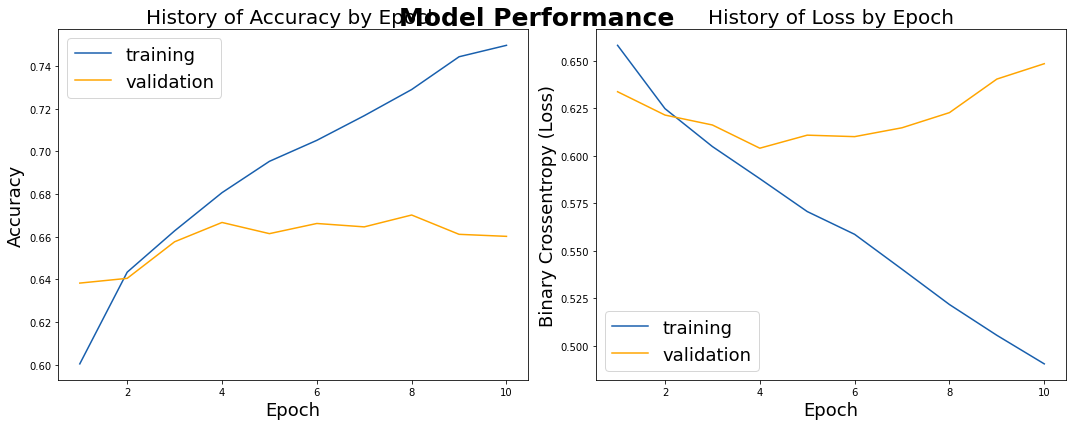

In [ ]:
Loss_Acc_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
# Predict classes 
predict_x=model.predict(x_test) 
#y_pred=np.argmax(predict_x,axis=1)
y_pred=np.round(predict_x).astype(int)

In [ ]:
target=['negative', 'positive']

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),2))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, predict_x,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=target))

Accuracy: 0.66
Precision: 0.6622
Recall: 0.6681
F1 Score: 0.6593
ROC AUC Score: 0.7196
		Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.80      0.74      3636
    positive       0.64      0.48      0.55      2658

    accuracy                           0.67      6294
   macro avg       0.66      0.64      0.64      6294
weighted avg       0.66      0.67      0.66      6294



### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.15, shear_range=0.15,zoom_range=0.15, channel_shift_range=10., horizontal_flip=True, fill_mode='nearest')
    
test_datagen = ImageDataGenerator()

batch_size = 8

In [ ]:
# DataGenerator
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
del x_train, y_train
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)
del x_test, y_test

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)

filepath = 'bone_fracture_baseline_model.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=1, save_best_only=True,mode='min')

callbacks = [checkpoint, es, reduce_lr]

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=(test_generator), shuffle=True, epochs=40, batch_size=64,callbacks=[es])

Epoch 1/40
3147/3147 [==============================] - 208s 62ms/step - loss: 0.6826 - accuracy: 0.5773 - val_loss: 0.6830 - val_accuracy: 0.5777
Epoch 2/40
3147/3147 [==============================] - 197s 62ms/step - loss: 0.6818 - accuracy: 0.5776 - val_loss: 0.6811 - val_accuracy: 0.5777
Epoch 3/40
3147/3147 [==============================] - 194s 62ms/step - loss: 0.6816 - accuracy: 0.5777 - val_loss: 0.6818 - val_accuracy: 0.5777
Epoch 4/40
3147/3147 [==============================] - 199s 63ms/step - loss: 0.6814 - accuracy: 0.5777 - val_loss: 0.6813 - val_accuracy: 0.5777
Epoch 5/40
3147/3147 [==============================] - 209s 66ms/step - loss: 0.6812 - accuracy: 0.5777 - val_loss: 0.6810 - val_accuracy: 0.5777
Epoch 6/40
3147/3147 [==============================] - 200s 63ms/step - loss: 0.6811 - accuracy: 0.5777 - val_loss: 0.6810 - val_accuracy: 0.5777
Epoch 7/40
3147/3147 [==============================] - 202s 64ms/step - loss: 0.6811 - accuracy: 0.5777 - val_loss: 0

### VGG 

In [ ]:
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)